# Introduction on Drowsiness Detection System

Nowadays drowsiness of drivers is one of the main reasons behind road accidents. It is natural for the drivers who take long drives to doze off behind the steering wheel. In this article, we will build a drowsiness detection system that will alert the driver as soon as he fell asleep.

# Installing and importing dependencies and Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2

# Pre-processing Datasets

In [2]:
labels = os.listdir("data2/train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

# Visualizing Random Image

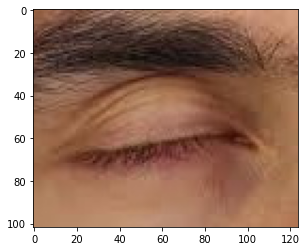

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("data2/train/Closed/_5.jpg"))

In [5]:
a = plt.imread("data2/train/yawn/10.jpg")

In [6]:
a.shape

(480, 640, 3)

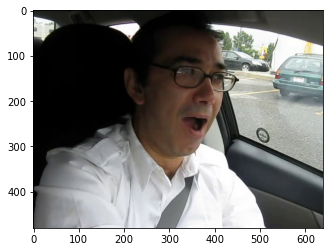

In [7]:
plt.imshow(plt.imread("data2/train/yawn/112.jpg"))

# Labeling dataset For Yawn and not Yawn

In [8]:
def face_for_yawn(directory="data2/train", face_cas_path="data2/prediction_images/haarcascade_frontalface_default.xml"):
    yawn_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(directory, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yawn_no.append([resized_array, class_num1])
    return yawn_no

yawn_no_yawn = face_for_yawn()

0
1


# Labeling dataset For Closed and Open

In [9]:
def get_data(dir_path="data2/train/", face_cas="data2/prediction_images/haarcascade_frontalface_default.xml", eye_cas="data2/prediction_images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

2
3


In [11]:
def append_data():
#     total_data = []
    yawn_no = face_for_yawn()
    data = get_data()
    yawn_no.extend(data)
    return np.array(yawn_no)

In [12]:
new_data = append_data()

0
1
2
3


C:\Users\DELL\AppData\Local\Temp\ipykernel_5256\1593140148.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yawn_no)


In [13]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# Train_test split

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [16]:
y = np.array(y)

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [18]:
len(X_test)

578

In [19]:
!pip install keras

In [20]:
!pip install tensorflow

# Fitting the model

In [21]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras

In [22]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [23]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [24]:
#history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

In [25]:
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(len(accuracy))

# plt.plot(epochs, accuracy, "b", label="trainning accuracy")
# plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
# plt.legend()
# plt.show()

# plt.plot(epochs, loss, "b", label="trainning loss")
# plt.plot(epochs, val_loss, "r", label="validation loss")
# plt.legend()
# plt.show()

In [26]:
# model.save("drowsiness_detection.h5")

In [27]:
# model.save("drowsiness_detection.model")

# Loading the model

In [28]:
model = tf.keras.models.load_model("drowsiness_detection.h5")

In [29]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

19/19 [==============================] - 36s 2s/step


In [30]:
predict_x

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [31]:
classes_x

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 1, 0, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 0, 3, 2, 3, 2, 2, 1,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 2, 0, 1, 2, 3, 3, 2, 0, 3, 3,
       0, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 0, 3, 3, 3, 3,
       3, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 0, 1, 3, 2, 2, 3, 3, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 1, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 3, 0, 2, 2, 1, 3, 2, 3, 1,

In [32]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

# Evaluating the model

In [33]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), classes_x, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.93      0.81      0.86        63
     no_yawn       0.84      0.95      0.89        74
      Closed       0.99      0.99      0.99       215
        Open       0.99      0.98      0.99       226

    accuracy                           0.96       578
   macro avg       0.94      0.93      0.93       578
weighted avg       0.96      0.96      0.96       578



In [34]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="data2/prediction_images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array//255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drowsiness_detection.h5")

# Model prediction

In [35]:
prediction = model.predict([prepare("data2/train/yawn/20.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 337ms/step


0

In [36]:
prediction = model.predict([prepare("data2/train/no_yawn/219.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 86ms/step


2

In [37]:
prediction = model.predict([prepare("data2/train/Closed/_321.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 84ms/step


2

In [38]:
prediction = model.predict([prepare("data2/train/Open/_14.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 92ms/step


2